In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import math

## TOKYO

,DateTime,Monthly Anamoly
5562,1880-01-01,-0.139
5563,1880-02-01,3.050
5564,1880-03-01,6.034
5565,1880-04-01,9.972
5566,1880-05-01,15.601


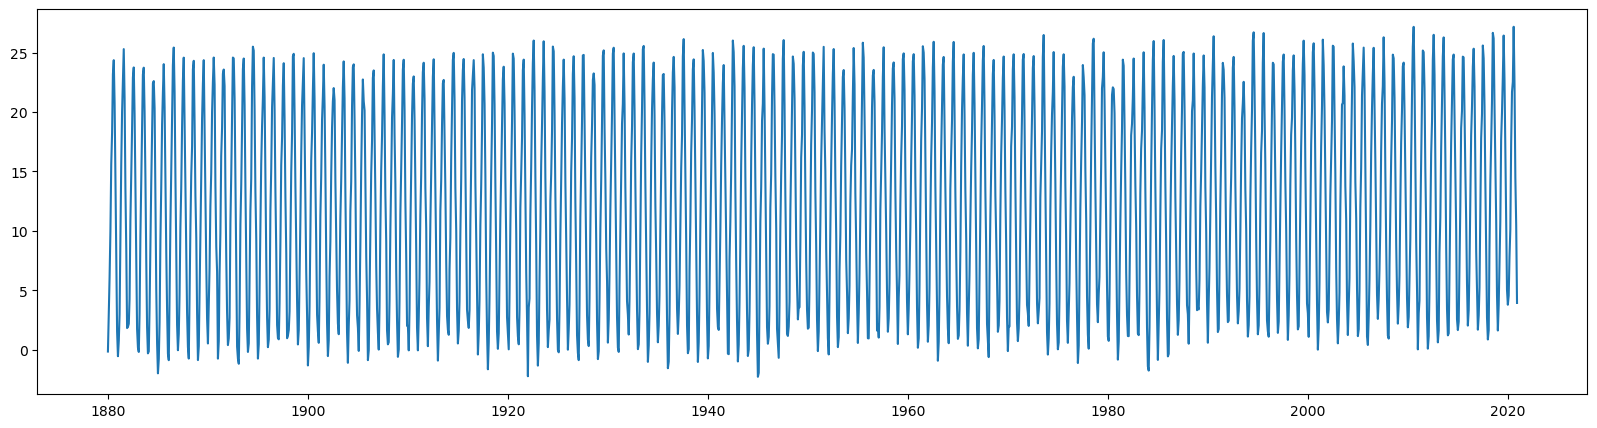

In [2]:
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 2]
rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01'] #NULL값 및 뚜렷한 추세 때문에 80년도 이후만 사용
display(rawdata.head())

plt.figure(figsize=(20,5))
plt.plot(rawdata.loc[:,"DateTime"], rawdata.loc[:,"Monthly Anamoly"])

In [3]:
display(rawdata)
rawdata.isnull().sum()

,DateTime,Monthly Anamoly
5562,1880-01-01,-0.139
5563,1880-02-01,3.050
5564,1880-03-01,6.034
5565,1880-04-01,9.972
5566,1880-05-01,15.601
...,...,...
7249,2020-08-01,27.166
7250,2020-09-01,22.270
7251,2020-10-01,14.491
7252,2020-11-01,10.471


DateTime           0
Monthly Anamoly    0
dtype: int64

In [4]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["Monthly Anamoly"] = min_max_scaler.fit_transform(rawdata["Monthly Anamoly"].to_numpy().reshape(-1,1))

In [5]:
rawdata

,DateTime,Monthly Anamoly
5562,1880-01-01,0.072079
5563,1880-02-01,0.180453
5564,1880-03-01,0.281860
5565,1880-04-01,0.415687
5566,1880-05-01,0.606980
...,...,...
7249,2020-08-01,1.000000
7250,2020-09-01,0.833617
7251,2020-10-01,0.569258
7252,2020-11-01,0.432645


In [6]:
train = rawdata.iloc[:-12*5, :]
data_train = train["Monthly Anamoly"].to_numpy()
print(data_train.shape)

# 예측해야할 5년치(60개월)
# 40년치(개월, iw)로 5년치(60개월,ow) 예측할 예정
test = rawdata.iloc[-12*5:, :]
data_test = test["Monthly Anamoly"].to_numpy()
print(data_test.shape)

(1632,)
(60,)


In [7]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        print(X.shape)
        Y = np.zeros([output_window, num_samples])
        print(Y.shape)

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        print(X.shape)
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(Y.shape)
        self.x = X
        self.y = Y
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return len(self.x)

In [8]:
iw = 12*40 #480
ow = 12*5 #60

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

(480, 1093)
(60, 1093)
(1093, 480, 1)
(1093, 60, 1)


In [9]:
print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[1].shape)

torch.Size([64, 480, 1])
torch.Size([64, 60, 1])


In [10]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers) 
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        ) 

    def forward(self, input_x):
        input_x = self.encoder(input_x)
        input_x = self.pos_encoder(input_x)
        output = self.transformer_encoder(input_x.transpose(0,1)).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe) #register_buffer로 layer를 등록하면 optimizer가 업데이트 하지 않음

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [11]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### ⚠️새로운 학습 진행

In [12]:
lr = 1e-4
model = TFModel(iw=12*40, ow=12*5, d_model=256, nhead=4, nlayers=2, dropout=0.1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
epoch = 100
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        result = model(inputs.float().to(device))
        loss = loss_func(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

  0%|          | 0/100 [00:00<?, ?it/s]

loss: 0.002161: 100%|██████████| 100/100 [12:26<00:00,  7.46s/it]


### ⚠️ 학습된 파라미터 불러오기(필요한 경우만)

lr = 1e-4
model = TFModel(iw=12*40, ow=12*5, d_model=256, nhead=4, nlayers=2, dropout=0.1).to(device)
params = torch.load("./best_params/SEOUL_TF_480iw_60ow_256d_4h_2l.pt")
print(params)
model.load_state_dict(params)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### ⚠️ 모델 저장

In [14]:
TFModel_seoul_params = model.state_dict()
torch.save(TFModel_seoul_params, "TOKYO_TF_480iw_60ow_256d_4h_2l.pt")

In [15]:
def evaluate():
    input = torch.tensor(data_train[-12*40:], dtype=torch.float32).reshape(1,-1,1).to(device).to(device)
    model.eval()
    predictions = model(input)
    return predictions.detach().cpu().numpy()

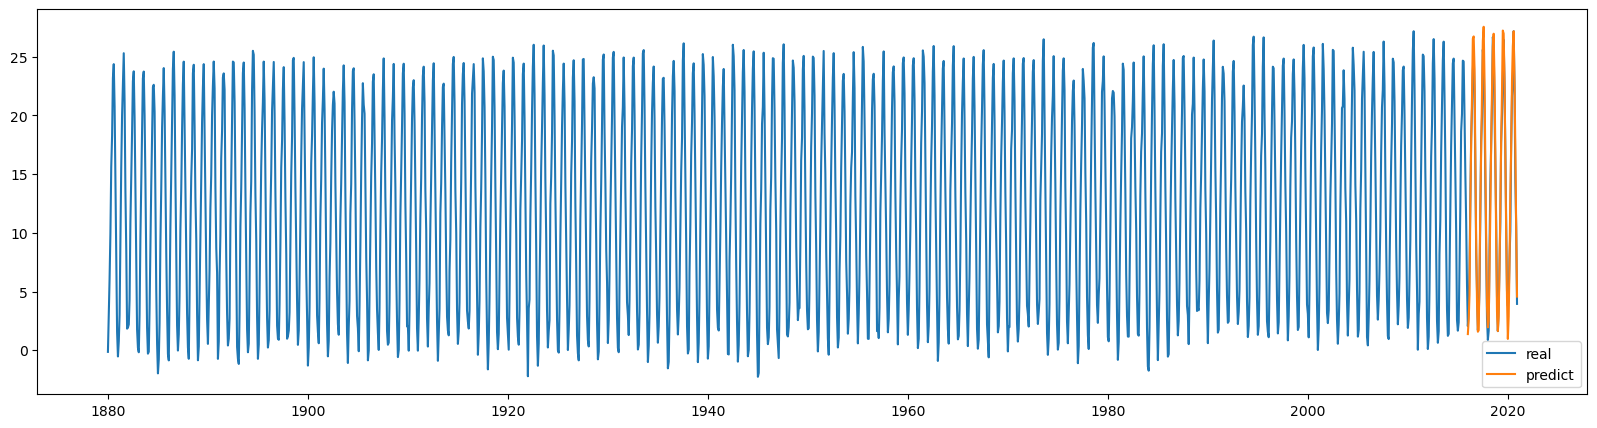

In [16]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = rawdata["Monthly Anamoly"].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(rawdata["DateTime"],real, label="real")
plt.plot(rawdata.iloc[-12*5:, 0],result, label="predict")
plt.legend()
plt.show()

In [17]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-12*5:])

15.241090022939272

# 2100년 까지 예측

In [18]:
plus_forecasting = rawdata.reset_index(drop=True)
plus_forecasting

,DateTime,Monthly Anamoly
0,1880-01-01,0.072079
1,1880-02-01,0.180453
2,1880-03-01,0.281860
3,1880-04-01,0.415687
4,1880-05-01,0.606980
...,...,...
1687,2020-08-01,1.000000
1688,2020-09-01,0.833617
1689,2020-10-01,0.569258
1690,2020-11-01,0.432645


In [19]:
with torch.no_grad():
    for predicted_year_counts in range(16):
        last_datetime = plus_forecasting.loc[plus_forecasting.index[-1], "DateTime"]
        new_datetimes = [(last_datetime + pd.DateOffset(months=i)) for i in range(1,61)]
        predict = model(torch.tensor(plus_forecasting.iloc[-12*40:, 1].to_numpy(), dtype=torch.float32).reshape(1,-1,1).to(device))

        new_df = pd.DataFrame(columns=["DateTime", "Monthly Anamoly"])
        new_df["DateTime"] = new_datetimes
        new_df["Monthly Anamoly"] = predict.cpu().reshape(-1).numpy()
        plus_forecasting = pd.concat([plus_forecasting, new_df], axis=0)
        plus_forecasting.reset_index(drop=True, inplace=True)

In [20]:
plus_forecasting

,DateTime,Monthly Anamoly
0,1880-01-01,0.072079
1,1880-02-01,0.180453
2,1880-03-01,0.281860
3,1880-04-01,0.415687
4,1880-05-01,0.606980
...,...,...
2647,2100-08-01,1.039622
2648,2100-09-01,0.900053
2649,2100-10-01,0.688463
2650,2100-11-01,0.449961


In [21]:
plus_forecasting["Monthly Anamoly"] = min_max_scaler.inverse_transform(plus_forecasting["Monthly Anamoly"].to_numpy().reshape(-1,1))

In [22]:
plus_forecasting.to_csv("./TF_forecast/tf_forecast_tokyo.csv", index=False, header=True)
plus_forecasting

,DateTime,Monthly Anamoly
0,1880-01-01,-0.139000
1,1880-02-01,3.050000
2,1880-03-01,6.034000
3,1880-04-01,9.972000
4,1880-05-01,15.601000
...,...,...
2647,2100-08-01,28.331926
2648,2100-09-01,24.224952
2649,2100-10-01,17.998703
2650,2100-11-01,10.980541


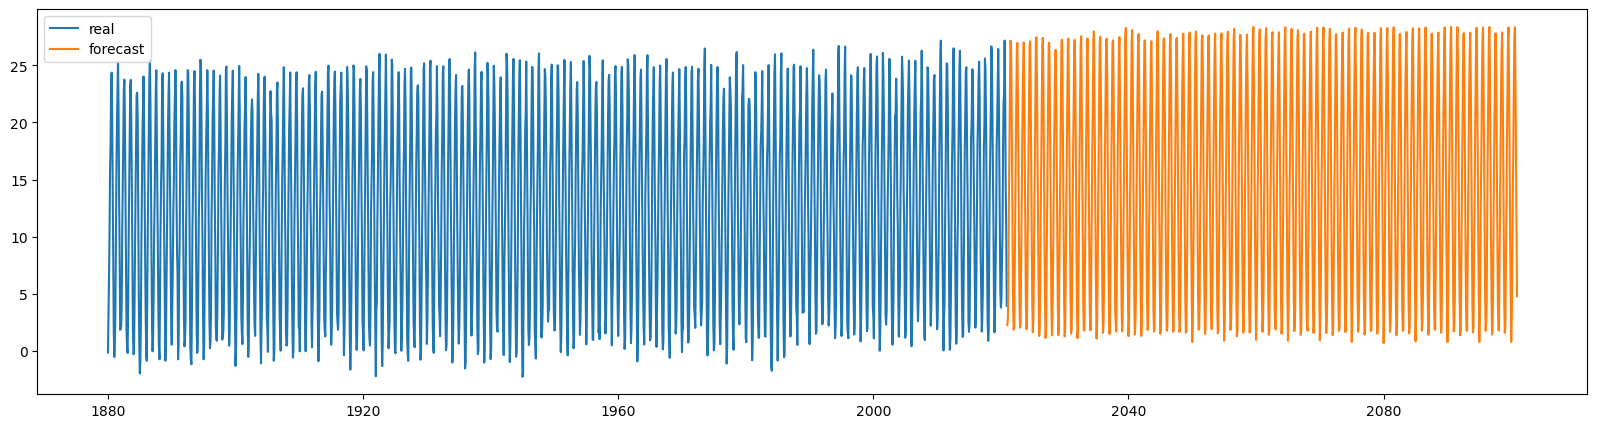

In [23]:
plt.figure(figsize=(20,5))
plt.plot(plus_forecasting.loc[plus_forecasting.loc[:,"DateTime"] <= pd.to_datetime('2020-12-01'), "DateTime"],
        plus_forecasting.loc[plus_forecasting.loc[:,"DateTime"] <= pd.to_datetime('2020-12-01'), "Monthly Anamoly"], label="real")
plt.plot(plus_forecasting.loc[plus_forecasting.loc[:,"DateTime"] > pd.to_datetime('2020-12-01'), "DateTime"],
        plus_forecasting.loc[plus_forecasting.loc[:,"DateTime"] > pd.to_datetime('2020-12-01'), "Monthly Anamoly"], label="forecast")
plt.legend()
plt.show()

In [24]:
month12_ma = plus_forecasting["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = plus_forecasting["Monthly Anamoly"].rolling(window=120).mean()

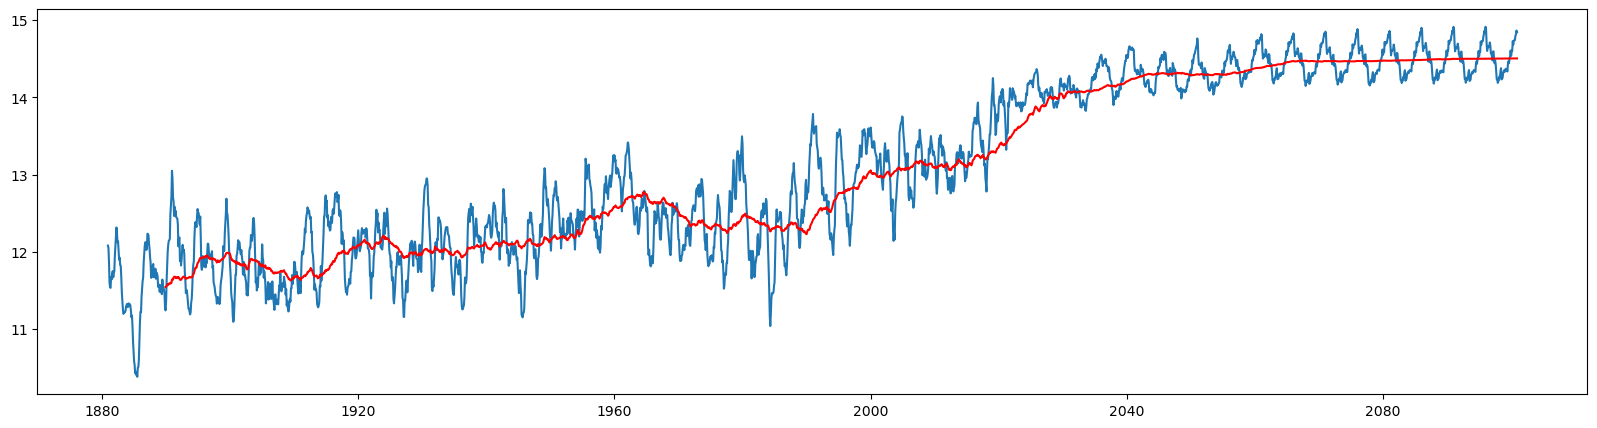

In [25]:
plt.figure(figsize=(20,5))
plt.plot(plus_forecasting['DateTime'],month12_ma)
plt.plot(plus_forecasting['DateTime'],year10_ma, color='red')